In [89]:
from mplsoccer import Pitch, FontManager, Sbopen, VerticalPitch
import numpy as np
from matplotlib.colors import to_rgba
import pandas as pd

In [90]:
# Spain vs Poland
MATCH_ID = 3788762
TEAM = 'Poland'
parser = Sbopen()
events, related, freeze, players = parser.event(MATCH_ID)


In [91]:
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[
    events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[[
    'tactics_id', 'tactics_formation']].ffill()

In [92]:
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.position_id.map(formation_dict)

In [93]:
sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [94]:
# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                    axis='columns'), 
                                    on=['tactics_id', 'pass_recipient_id'],
                                    how='left', 
                                    validate='m:1', 
                                    suffixes=['', '_receipt'])

events['tactics_formation'] = events['tactics_formation'].astype(int)

In [95]:
events.groupby('team_name').tactics_formation.unique()

team_name
Poland    [352, 343]
Spain          [433]
Name: tactics_formation, dtype: object

In [96]:
FORMATION = 352
pass_cols = ['id', 'position_abbreviation', 'position_abbreviation_receipt']
passes_formation = events.loc[(events.team_name == TEAM) & (events.type_name == 'Pass') &
                              (events.tactics_formation == FORMATION) &
                              (events.position_abbreviation_receipt.notnull()), pass_cols].copy()
location_cols = ['position_abbreviation', 'x', 'y']
location_formation = events.loc[(events.team_name == TEAM) &
                                (events.type_name.isin(['Pass', 'Ball Receipt'])) &
                                (events.tactics_formation == FORMATION), location_cols].copy()

In [97]:
# average locations
average_locs_and_count = (location_formation.groupby('position_abbreviation')
                          .agg({'x': ['mean'], 'y': ['mean', 'count']}))
average_locs_and_count.columns = ['x', 'y', 'count']

In [98]:
# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = (passes_formation[['position_abbreviation','position_abbreviation_receipt']].max(axis='columns'))
passes_formation['pos_min'] = (passes_formation[['position_abbreviation','position_abbreviation_receipt']].min(axis='columns'))
passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

In [99]:
# add on the location of each player so we have the start and end positions of the lines
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True,
                                      suffixes=['', '_end'])

In [100]:
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() * MAX_LINE_WIDTH)
average_locs_and_count['marker_size'] = (average_locs_and_count['count'] / (average_locs_and_count['count'].max()  * 3) * MAX_MARKER_SIZE)

In [101]:
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (0.8 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

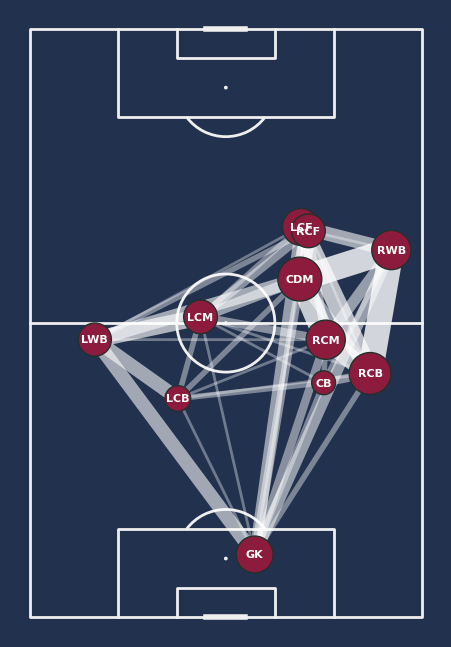

In [102]:
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22314E', line_color='#efefef')
fig, ax = pitch.draw(figsize=(4.4, 6.4), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22314E")

pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y,
                           s=average_locs_and_count.marker_size,
                           color='#8D1B3D', edgecolors='#22312b', linewidth=1, alpha=1, ax=ax)

for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=8, weight='bold', ax=ax)